## Chapter 10

### 10.1 Regression with GBMs: preparing the data

This approach will be perhaps the easiest one to understand/use. We have user features, item features and a target (the *interest*). Therefore, this is just a usual supervised problem where we will fit a regressor, in particular, [lightGBM](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf). Since this is a "standard" technique I will use this opportunity to illustrate a variety of tools around ML in general and boosted methods in particular. 

As always, let's start defining some useful names

In [1]:
import numpy as np
import pandas as pd
import random
import os
import pickle
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import warnings
import multiprocessing

from joblib import Parallel, delayed
from recutils.average_precision import mapk
from functools import reduce
from hyperopt import hp, tpe, fmin, Trials

import seaborn as sns
import matplotlib.pyplot as plt
import lime
import shap

from lime.lime_tabular import LimeTabularExplainer
from eli5.sklearn import PermutationImportance
from eli5 import explain_weights, explain_weights_df,explain_prediction_df

%matplotlib inline
sns.set()
shap.initjs()

from sklearn.externals import joblib

warnings.filterwarnings("ignore")
cores = multiprocessing.cpu_count()

inp_dir = "../datasets/Ponpare/data_processed/"
train_dir = "train"
valid_dir = "valid"

Before we start loading the data, let me add a comment. In general, when using boosted methods, the presence of correlated features is not a big deal, since these will be ignored through the boosting rounds. However, for clarity and to reduce the chances of overfitting, we will select a subset of features here. All the numerical features have corresponding categorical ones, so we will keep the numerical when when possible in moving forward. In addition, if we remember, for valid period, validend and validfrom, we used two methods to impute NaN. 

1. Method1: Considering NaN as another category and 
2. Method2: replace NaN first in the object or numeric column and then turning the column into categorical. 

In this notebook, we will use we will use Method1. Feel free to use the categorical features computed with Method2 and see how the results compare

In [31]:
# train coupon features
df_coupons_train_feat = pd.read_pickle(os.path.join(inp_dir, train_dir, 'df_coupons_train_feat.p'))

drop_cols = [c for c in df_coupons_train_feat.columns
    if ((not c.endswith('_cat')) or ('method2' in c)) and (c!='coupon_id_hash')]
df_coupons_train_cat_feat = df_coupons_train_feat.drop(drop_cols, axis=1)

In [32]:
# train coupon features
df_users_train_feat = pd.read_pickle(os.path.join(inp_dir, train_dir, 'df_user_train_feat.p'))

# interest dataframe
df_interest = pd.read_pickle(os.path.join(inp_dir, train_dir, 'df_interest.p'))

df_train = pd.merge(df_interest, df_users_train_feat, on='user_id_hash')
df_train = pd.merge(df_train, df_coupons_train_cat_feat, on = 'coupon_id_hash')

# for the time being we ignore the "recency" element. In the next example/notebook we will make use of it
# df_train.drop(['user_id_hash','coupon_id_hash','recency_factor'], axis=1, inplace=True)

Let's prepare the data

In [33]:
train = df_train.drop(['user_id_hash','coupon_id_hash','recency_factor', 'interest'], axis=1)
y_train = df_train.interest
all_cols = train.columns.tolist()
cat_cols = [c for c in train.columns if c.endswith("_cat")]

print(train.shape)
train.head()

(1560464, 85)


,age,pref_name_cat,sex_id_cat,catalog_price_mean,catalog_price_median,catalog_price_min,catalog_price_max,discount_price_mean,discount_price_median,discount_price_min,discount_price_max,catalog_price_0,catalog_price_1,catalog_price_2,discount_price_0,discount_price_1,discount_price_2,top1_capsule_text_cat,top2_capsule_text_cat,top3_capsule_text_cat,top1_genre_name_cat,top2_genre_name_cat,top3_genre_name_cat,view_catalog_price_mean,view_catalog_price_median,view_catalog_price_min,view_catalog_price_max,view_discount_price_mean,view_discount_price_median,view_discount_price_min,view_discount_price_max,view_catalog_price_0,view_catalog_price_1,view_catalog_price_2,view_discount_price_0,view_discount_price_1,view_discount_price_2,view_top1_capsule_text_cat,view_top2_capsule_text_cat,view_top3_capsule_text_cat,view_top1_genre_name_cat,view_top2_genre_name_cat,view_top3_genre_name_cat,view_coupon_id_hash_count,view_coupon_id_hash_nunique,view_session_id_hash_nunique,view_day_of_week_nunique,view_min_time_diff,view_max_time_diff,view_median_time_diff,view_top1_dayofweek_cat,view_top2_dayofweek_cat,purchaseid_hash_count,coupon_id_hash_nunique,item_count_sum,small_area_name_nunique,day_of_week_nunique,median_time_diff,top1_small_area_name_cat,top2_small_area_name_cat,top1_dayofweek_cat,top2_dayofweek_cat,usable_date_mon_cat,usable_date_tue_cat,usable_date_wed_cat,usable_date_thu_cat,usable_date_fri_cat,usable_date_sat_cat,usable_date_sun_cat,usable_date_holiday_cat,usable_date_before_holiday_cat,validperiod_method1_cat,validfrom_method1_cat,validend_method1_cat,dispfrom_cat,dispend_cat,dispperiod_cat,price_rate_cat,catalog_price_cat,discount_price_cat,capsule_text_cat,genre_name_cat,large_area_name_cat,ken_name_cat,small_area_name_cat
0,26,2,1,883.142857,1000.0,1.0,2520.0,340.000000,100.0,0.0,1580.0,0.0,7.0,0.0,7.0,0.0,0.0,9,8,0,9,8,0,8724.375000,4000.0,1060.0,47355.0,2459.125000,1735.0,100.0,9900.0,6.0,4.0,1.0,6.0,4.0,1.0,6,8,11,6,8,11,34.0,16.0,16.0,6.0,0.0,76.0,0.0,1,2,7.0,7.0,7.0,3.0,4.0,32.5,2,16,2,1,3,3,3,3,3,3,3,3,3,4,7,7,6,2,1,0,0,1,6,6,4,41,49
1,55,43,1,5817.661538,4000.0,930.0,41200.0,2469.061538,1700.0,450.0,14800.0,17.0,29.0,5.0,30.0,6.0,15.0,0,6,10,0,6,10,13100.038095,6800.0,500.0,105000.0,6062.982540,2980.0,100.0,39600.0,162.0,136.0,186.0,132.0,146.0,206.0,0,6,12,11,0,6,1034.0,641.0,284.0,7.0,0.0,10.0,0.0,5,6,65.0,51.0,109.0,7.0,7.0,4.0,3,26,5,1,3,3,3,3,3,3,3,3,3,4,7,7,6,2,1,0,0,1,6,6,4,41,49
2,45,5,0,6461.058824,3630.0,1890.0,28000.0,2439.588235,1500.0,500.0,10000.0,3.0,11.0,3.0,10.0,2.0,5.0,6,0,11,6,0,11,7456.093809,4515.0,1.0,63000.0,2816.266417,1980.0,0.0,30000.0,234.0,135.0,113.0,250.0,160.0,72.0,6,0,12,6,0,11,765.0,594.0,188.0,7.0,0.0,22.0,0.0,6,2,17.0,17.0,25.0,9.0,7.0,16.5,13,20,0,2,3,3,3,3,3,3,3,3,3,4,7,7,6,2,1,0,0,1,6,6,4,41,49
3,65,5,0,6468.560000,4730.0,500.0,17000.0,2469.120000,1940.0,100.0,8500.0,10.0,11.0,4.0,15.0,4.0,6.0,6,12,9,6,11,9,9465.822830,5980.0,1.0,108000.0,3981.394768,2500.0,0.0,35800.0,253.0,273.0,178.0,263.0,228.0,213.0,0,6,11,0,11,6,1082.0,878.0,265.0,7.0,0.0,8.0,0.0,1,6,25.0,25.0,31.0,9.0,7.0,6.5,2,13,3,0,3,3,3,3,3,3,3,3,3,4,7,7,6,2,1,0,0,1,6,6,4,41,49
4,62,7,0,3351.666667,3310.0,500.0,10000.0,1414.222222,999.0,100.0,5000.0,2.0,6.0,0.0,6.0,1.0,1.0,0,6,9,0,6,9,9899.158333,4635.0,1.0,73400.0,3908.275000,1990.0,0.0,29800.0,43.0,21.0,23.0,45.0,19.0,23.0,6,0,12,6,0,11,139.0,99.0,65.0,7.0,0.0,23.0,0.0,3,5,9.0,8.0,16.0,3.0,4.0,24.0,9,2,4,5,3,3,3,3,3,3,3,3,3,4,7,7,6,2,1,0,0,1,6,6,4,41,49


In moving forward, I will use `lightGBM` (instead of [catboost](http://learningsys.org/nips17/assets/papers/paper_11.pdf) or [xgboost](https://arxiv.org/pdf/1603.02754.pdf)), the reasons are two:

1. `LightGBM` treats categorical features directly, without the need of one-hot encoding them. However, this also applies to `Catboost`, so here is the second reason  
2. It is just so **FAST**.

Let me just comment a bit around these points. In general, `sklearn` algorithms, do not deal with categorical features. In other words, when passed to an algorithm they will be treated as numbers, implying an ordinality that in reality makes no sense. For example, let's say we have a feature that is `"type of pet"`, for which we have 3 categories: dog, cat and hamster. We encode them as 1, 2 and 3 and pass it to our decision tree, RF or GBM (without any other metadata). The algorithm will sort the values and "cat" will be *higher* than "dog". Also, `cat + dog = hamster (?)`.

As we all know the way to deal with categorical features is by one-hot encode them. However, if you have a lot of category values, you'll face the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). By the time of writing, there are some implementations that deal automatically with categorical features. The GBM implementation in the `h2o` library comes with a series of encoding options, including [histograms and binning](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm-faq/histograms_and_binning.html). The `RandomForest` or `GradientBoostedTrees` methods at the `MLlib` library in spark deal with categorical features through information the corresponding [metadata](https://spark.apache.org/docs/latest/ml-classification-regression.html). 

Coming back to our example here, `XGBoost` deals well with large and sparse datasets. Therefore, is always an option (still one needs to one-hot encode). `Catboost` treats directly categorical features in a very elegant way (see the page 2 in [their paper](http://learningsys.org/nips17/assets/papers/paper_11.pdf)). However, I often find it a bit slower than `lightGBM`, which also offers a direct treatment of categorical features (see page 16 in [this document](https://media.readthedocs.org/pdf/lightgbm/latest/lightgbm.pdf) and their reference [8]). 

Let's have a look simply to the data preparation. The three algorithms offer native methods that are often faster than the `sklearn` API. To use their methods we need to turn the data into their data format.

In [34]:
from time import time
start = time()
lgtrain = lgb.Dataset(train,
    label=y_train,
    feature_name=all_cols,
    categorical_feature = cat_cols,
    free_raw_data=False)
end = time() - start
print(end)

0.001321554183959961


In [35]:
cat_indx = [i for (i,c) in enumerate(all_cols) if c in cat_cols]

In [36]:
start = time()
ctb.Pool(train,
    label=y_train,
    cat_features=cat_indx
)
end = time() - start
print(end)

31.98755121231079


I will leave to the reader to run the `train` or `cv` methods for `lightGBM` and `Catboost` to see that the former is also faster, while performance is nearly identical. For all this, I decided to use `lightGBM`.

So why is `lightGBM` so fast? To me this is because of the two algorithms that run behing the booster. These are: 

1. Gradient-based One-Side Sampling (GOOS): this algorithm keeps all the instances with large gradients and performs random sampling on the instances with smaller gradients amplifying the sampled data with a constant.
    
2. Exclusive Feature Bundling (EFB): this method recognises the fact that in a sparse feature space, many features are mutually exclusive. One can bundle exclusive features into a single feature. 

GOOS reduces the number of instances one has to analyze while EFB reduces the number of features while preserving performance. The two of them combined result in an incredibly fast algorithm. Of course, if you are going to use `lightGBM` reading [the paper](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf) is a must. All details related to GOOS and EFB are there, along with pseudo code. 

Let's now move on (the code below should be familiar to you if you already went through previous notebooks)

In [37]:
# Read the validation coupon features
df_coupons_valid_feat = pd.read_pickle(os.path.join(inp_dir, 'valid', 'df_coupons_valid_feat.p'))
df_coupons_valid_cat_feat = df_coupons_valid_feat.drop(drop_cols, axis=1)

# Read the interactions during validation
interactions_valid_dict = pickle.load(
    open("../datasets/Ponpare/data_processed/valid/interactions_valid_dict.p", "rb"))

# Build a validation dataframe with the cartesian product between the 358 validation coupons 
# and the 6071 users seen in training AND validation
left = pd.DataFrame({'user_id_hash':list(interactions_valid_dict.keys())})
left['key'] = 0
right = df_coupons_valid_feat[['coupon_id_hash']]
right['key'] = 0
df_valid = (pd.merge(left, right, on='key', how='outer')
    .drop('key', axis=1))
df_valid = pd.merge(df_valid, df_users_train_feat, on='user_id_hash')
df_valid = pd.merge(df_valid, df_coupons_valid_cat_feat, on = 'coupon_id_hash')
X_valid = (df_valid
    .drop(['user_id_hash','coupon_id_hash'], axis=1)
    .values)
df_eval = df_valid[['user_id_hash','coupon_id_hash']]
print(X_valid.shape)
print(df_eval.shape)
df_eval.head()

(2173418, 85)
(2173418, 2)


,user_id_hash,coupon_id_hash
0,002ae30377cd30f65652e52618e8b2d6,282b5bda1758e147589ca517e02195c3
1,002b08971471e6083dd716f6c3bb6572,282b5bda1758e147589ca517e02195c3
2,003a7b4941222b7e507fdc9e95de2cc1,282b5bda1758e147589ca517e02195c3
3,00441c9b51cfe60b82bdf7a20ad79fc8,282b5bda1758e147589ca517e02195c3
4,00454d0ad87f2e423cc3cc201fde8c8c,282b5bda1758e147589ca517e02195c3


### 10.2 Optimizing

GBMs have a large number of parameters to optimize (that being said, all 3 packages work well "out of the box"). In this section I will describe two approaches to optimize these parameters and use one of them. Note that I will not go into detail on what these parameters mean. If requested I could perhaps add a section just on that. Nonetheless, one could always have a look in this [link](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst#objective-parameters) for `lightGBM`, [here](https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst) for `Xgboost` and [here](https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_parameters-list-docpage/) for `Catboost`.

#### 10.2.1 Sequential optimization

When optimizing GBMs, in particular, tree-based methods, there is a hierarchy associated to the parameters. For example, tuning the `number of boosting rounds`  is often more critical that tuning the `minimum child weight`. With that in mind, I normally tune the parameters in the following order:

1. Set high learning rate and tune number of estimators with early stopping to avoid overfitting
2. Tree maximum depth and minimum child weight
3. Minimum split gain
4. Sample parameters
5. Regularization
6. Finally fine tuning the learning rate and number of estimators

There is a script called `gbm_optimizer.py` at the `recutils` directory that contains the code to run this optimization process. 

To run it, simply uncomment the code in the cell below

In [35]:
# from recutils.gbm_optimizer import LGBOptimizer
# X_train = train.values
# mod1 = lgb.LGBMRegressor()
# optimizer = LGBOptimizer(model=mod1, feature_names=all_cols, categorical_feat=cat_cols, n_evals=20)
# optimizer.full_optimization(X_train, ytrain)

After running this, the `optimizer` object will have an attribute called `params` that will contain the optimal parameters. Just pass them to your model: `mod_opt = lgb.LGBMRegressor(**optimal_params)`, and off you go, `fit` and `predict`.

#### 10.2.2 All at once with Hyperopt

We have already seen `hyperopt` in action in previous notebooks. We simply need to define a parameter space, an objective function and run the whole thing. This is the approach I will use here. Let's have a look to the code. We first define a parameter space

In [38]:
# defining the parameter space
lgb_parameter_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'num_boost_round': hp.quniform('num_boost_round', 50, 500, 50),
    # equivalent to a max tree depth of 10 if you'd use xgboost
    'num_leaves': hp.quniform('num_leaves', 30,1024,5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 50, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.),
    'subsample': hp.uniform('subsample', 0.5, 1.),
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 1.),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 1.),
}

When defining the objective function there is an important aspect to consider. Normally we would optimize using the corresponding evaluation metric for a given problem and algorithm, for example the `rmse` in this case. However, here we are ultimately interested in the `MAP@10`. Therefore, we need to optimize using that metric. 

A priori, assuming that our interest metric represents perfectly users' interest in some items, the results obtained with the two metrics would be very similar if not nearly identical. However, chances are that our measure of interest suffers from some flaws or has some inherent biases that are hard to find and/or fix. In this scenario it is possible that the best `rmse` does not lead to the best `MAP`. 

Optimizing using `MAP` ensures the best possible recommendations given a certain technique. 

With all that in mind, let's build the objective function

In [39]:
def lgb_objective_map(params):
    """
    objective function for lightgbm using MAP as success metric.
    """

    # hyperopt casts as float
    params['num_boost_round'] = int(params['num_boost_round'])
    params['num_leaves'] = int(params['num_leaves'])

    # need to be passed as parameter
    params['verbose'] = -1
    params['seed'] = 1

    # Cross validation
    cv_result = lgb.cv(
    params,
    lgtrain,
    nfold=3,
    metrics='rmse',
    num_boost_round=params['num_boost_round'],
    early_stopping_rounds=20,
    stratified=False,
    )

    # Update the number of trees based on the early stopping results
    early_stop_dict[lgb_objective_map.i] = len(cv_result['rmse-mean'])
    params['num_boost_round'] = len(cv_result['rmse-mean'])

    # fit and predict
    model = lgb.LGBMRegressor(**params)
    model.fit(train,y_train,feature_name=all_cols,categorical_feature=cat_cols)
    preds = model.predict(X_valid)

    # add a column with predictions and rank
    df_eval['interest'] = preds
    df_ranked = df_eval.sort_values(['user_id_hash', 'interest'], ascending=[False, False])
    df_ranked = (df_ranked
        .groupby('user_id_hash')['coupon_id_hash']
        .apply(list)
        .reset_index())
    recomendations_dict = pd.Series(df_ranked.coupon_id_hash.values,
        index=df_ranked.user_id_hash).to_dict()

    # calculate the MAP
    actual = []
    pred = []
    for k,_ in recomendations_dict.items():
        actual.append(list(interactions_valid_dict[k]))
        pred.append(list(recomendations_dict[k]))

    result = mapk(actual,pred)
    print("INFO: iteration {} MAP {:.3f}".format(lgb_objective_map.i, result))

    lgb_objective_map.i+=1

    return 1-result

#### 10.2.3 Caveat around the number of boosted rounds

Both optimising approaches described in 2.1 and 2.2 have their pros and cons. In particular, when performing sequential optimisation, the number of boosting round is first optimised and then fixed for most of the process until it is fine tuned at the end. This gives control and clarity regarding the value of that parameter. However, we miss the wholistic view of the optimisation process (i.e. taking into account the effect between all parameters in the parameter space) relying on the fact that some parameters are more relevant than others. 

On the other hand, when using `hyperopt`, the algorithm will optimise based on the input value of the parameters, one being `num_boost_round`. Within the objective function we do cross validation with early stopping to avoid overfitting. This means that the final number of boosting round might differ from the input value. This information will get "lost" within the optimisation process. To rememdy this situation we simply save the final `num_boost_round`  to the dictionary `early_stop_dict`. 

Let me illustrate the issue with an example. Let's say that the `num_boost_round` input value for the iteration number 15 is 100 and the best result so far during the process is obtained for that particular iteration. After using `cv` we find out that only 35 trees are needed before overfitting happens. In the next iteration, the information that `hyperopt` will use is that, so far, the best iteration happened when using 100 boosting rounds. Then it will move in that direction in the optimisation process (i.e. the bayesian process will "point" towards `num_boost_round` values around 100). 

This is of course a limitation of this approach, but its advantages (speed, fast convergence and a wholistic optimisation process) make me lean towards this technique. Ultimately, the parameters provided by `hyperopt` will still be those corresponding to the best iteration and we simply need to replace the output `num_boost_round` value with the corresponding value at `early_stop_dict`. 

With all that in mind, let's hyperopt the hell out of it!

In [17]:
# I am going to run 50 iterations. Of course, one could refine the results by running a few more. 
# I never managed to get anything beyond 0.032
start = time()
early_stop_dict = {}
trials = Trials()
lgb_objective_map.i = 0
best = fmin(fn=lgb_objective_map,
            space=lgb_parameter_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)
best['num_boost_round'] = early_stop_dict[trials.best_trial['tid']]
best['num_leaves'] = int(best['num_leaves'])
best['verbose'] = -1
print(1-trials.best_trial['result']['loss'])
end = time() - start
print("INFO: optimization time was {} min".format(round(end/60., 3)))

INFO: iteration 0 MAP 0.020
INFO: iteration 1 MAP 0.023
INFO: iteration 2 MAP 0.018
INFO: iteration 3 MAP 0.028
INFO: iteration 4 MAP 0.023
INFO: iteration 5 MAP 0.023
INFO: iteration 6 MAP 0.025
INFO: iteration 7 MAP 0.030
INFO: iteration 8 MAP 0.029
INFO: iteration 9 MAP 0.022
INFO: iteration 10 MAP 0.015
INFO: iteration 11 MAP 0.027
INFO: iteration 12 MAP 0.022
INFO: iteration 13 MAP 0.020
INFO: iteration 14 MAP 0.020
INFO: iteration 15 MAP 0.017
INFO: iteration 16 MAP 0.024
INFO: iteration 17 MAP 0.027
INFO: iteration 18 MAP 0.026
INFO: iteration 19 MAP 0.019
INFO: iteration 20 MAP 0.024
INFO: iteration 21 MAP 0.027
INFO: iteration 22 MAP 0.024
INFO: iteration 23 MAP 0.020
INFO: iteration 24 MAP 0.027
INFO: iteration 25 MAP 0.026
INFO: iteration 26 MAP 0.029
INFO: iteration 27 MAP 0.028
INFO: iteration 28 MAP 0.025
INFO: iteration 29 MAP 0.027
INFO: iteration 30 MAP 0.028
INFO: iteration 31 MAP 0.027
INFO: iteration 32 MAP 0.025
INFO: iteration 33 MAP 0.022
INFO: iteration 34 MAP 0

In [29]:
# before we move on let's save the parameters
print(best)
pickle.dump(best, open("../datasets/Ponpare/data_processed/models/gbm_optimal_parameters.p", "wb"))

# fit the model
model = lgb.LGBMRegressor(**best)
model.fit(train,y_train,feature_name=all_cols,categorical_feature=cat_cols)

{'colsample_bytree': 0.5674860470444466, 'learning_rate': 0.07455978764708766, 'min_child_weight': 12.0, 'num_boost_round': 448, 'num_leaves': 165, 'reg_alpha': 0.5601417274041981, 'reg_lambda': 0.22481938523013634, 'subsample': 0.6983060914579524, 'verbose': -1}


LGBMRegressor(boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.5674860470444466,
       learning_rate=0.07455978764708766, max_depth=-1,
       min_child_samples=20, min_child_weight=12.0, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_boost_round=448, num_leaves=165,
       objective=None, random_state=None, reg_alpha=0.5601417274041981,
       reg_lambda=0.22481938523013634, silent=True,
       subsample=0.6983060914579524, subsample_for_bin=200000,
       subsample_freq=0, verbose=-1)

In [14]:
# load best parameters
# best = pickle.load(open("../datasets/Ponpare/data_processed/models/gbm_optimal_parameters.p", "rb"))

In [40]:
# # save model
# joblib.dump(model, "../datasets/Ponpare/data_processed/models/lgbmodel.p")
# # load model
model = joblib.load("../datasets/Ponpare/data_processed/models/lgbmodel.p")

So far this is the best result, **MAP@10 = 0.032**. 

### 10.3 Interpreting the results

Finally, I will briefly touch here on model interpretability. The following code is based on this [post](http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html), which is simply **fantastic**. Note that some of the techniques there are hard to implement with categorical features or when the data is relatively big. Nonetheless, I strongly recommend going through that entire post. 

Here I will use [eli5](https://github.com/TeamHG-Memex/eli5), [lime](https://github.com/marcotcr/lime) and [shap](https://github.com/slundberg/shap). 

#### 10.3.1 ELI5

`Eli5` wraps up and enhances the `feature_importance` attribute for many existing algorithms. In addition, has a permutation importance method (`PermutationImportance`) that measures the feature importance by looking at how much the score decreases when a feature is not available. If you want to know more about the algorithm itself have a look [here](https://media.readthedocs.org/pdf/eli5/latest/eli5.pdf), section 4.2.1. Note that this method is only suitable when the number of features is not too large. Finally `eli5` uses `lime` to explain individual predictions through the method `explain_prediction_df`, so let's have a look to `lime`. 

Of course, this is an **extremely** short summary of all that `eli5` can do. For more details, please, read the [docs](https://eli5.readthedocs.io/en/latest/tutorials/index.html)). 

#### 10.3.2 LIME

`Lime` stands for Local Interpretable Model Agnostic Explanations. `Lime` explains the predictions of any classifier in an interpretable and faithful manner, by learning an interpretable model (linear model, decision trees) locally around the prediction. In [their paper](https://arxiv.org/pdf/1602.04938.pdf) they focuse on linear models as explanations. Let me add that I quite like their paper. I am not a mathematician or statistician and I found the paper quite accessible and useful. Let's see if I manage to explain what the algorithm does at high level in plane english. 

There are two main mathematical expression that we need to care about:

$$\xi(x) = \text{argmin}_{g \in G}\;\;\mathcal{L}(f, g, \pi_x) + \Omega(g) \hspace{5mm} \text{(1)}$$

where $\xi(x)$ is the explanation of the prediction obtained for the observation $x$. $\mathcal{L}(f, g, \pi_x)$ is a measure of how unfaithful $g$ (approximate model) is in approximating $f$ (the real model) in the locality of $x$ defined by $\pi_x$. Finally $\Omega(g)$ is a measure of complexity of the explanation $g$. As described in their paper, for decision trees $\Omega(g)$ may be the depth of the tree, while for linear models, $\Omega(g)$ may be the number of non-zero weights. Therefore,  an quoting directly from their paper: *"in order to ensure both interpretability and local fidelity, we must minimize $\mathcal{L}(f, g, \pi_x)$ while having $\Omega(g)$ be low enough to be interpretable by humans"*. In other words, **we want a good local approximation that is not too complex**. 

That *"faithfulness"* of the approximation can be defined as:

$$\mathcal{L}(f, g, \pi_x) = \sum_{z, z' \in \mathcal{Z}}\pi_x(z)\left(f(z) - g(z')\right)^2 \hspace{5mm} \text{(2)}$$

Where $\mathcal{Z}$ is the space of the so called perturbed samples. I must admit that this expression confuses me a bit. Mostly the summation where $z,z' \in \mathcal{Z}$, as I would assume that $z$ and $z'$ belong to different spaces. Maybe is just notation but let me elaborate.

In their paper, they explain how if we denote $x \in \mathbb{R}^d$ a real observation, we could use $x' \in \{0,1\}^m$ to denote the binary vector used for its interpretable representation. With this notation, $\mathcal{Z}$ is the space of perturbed samples of $x$ and $z \in \mathbb{R}^d$. Then, to my understanding, there should be a $\mathcal{Z}'$ space of perturbed samples of $x'$, where $z' \in \{0,1\}^m$ and the summation should be over $z$,$z$ $\in \mathcal{Z}$,$\mathcal{Z'}$.

Moving on, and assuming that we approximate the predictions using a linear model $g(z') = w_g \cdot z'$ and $\pi_x(z) = exp(-D(x,z)^2 / \sigma^2)$ an exponential kernel defined on some distance function $D$, Equation 2 can be writen as: **the faithfulness of our local aproximation is equal to the summation of the squared differences between the real model predictions in the vicinity of $x$ and the corresponding linear approximations in the vicinity of $x'$ multiplied by a kernel $\pi_x$ defined on some distanced (e.g. L2)**

#### 10.3.3 SHAP

`Shap` (SHapley Additive exPlanations) goes a step further and represents a unified approach to explain the output of any machine learning model. 

By definition, additive feature attribution methods have an explanation model that is a linear function of binary variables:

$$g(z') = \phi_0 + \sum_{i=1}^{m} \phi_iz_{i}^{'} \hspace{5mm} \text{(3)}$$ 

where $z' \in \{0, 1\}^m$, m is the number of simplified input features (this should be familiar to us from the previous section), and $\phi_i \in \mathbb{R}$.

Then Lundberg and Lee (the authors of [the paper](https://arxiv.org/abs/1705.07874)) show that the only one possible explanation model $g$ that follows the properties of **local accuracy, missingness and consistency** (please read the paper for details on these properties) is defined as: 

$$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(m - |S| -1)!}{m!} \left [ f_x(S \cup \{i\}) - f_x(S) \right ] \hspace{5mm} \text{(4)}$$

Where $S$ is the set of non-zero indexes in $z'$ and $N$ is the set of all input features. These are the **Shapley values**. 

These results is important because, since `LIME` is an additive feature attribution method, the Shapley values are the only possible solution to Equation 3 (and 1) that satisfies Properties – local accuracy, missingness and consistency. 

But enough of math! to the code. 

In [41]:
# create our dataframe of feature importances
feat_imp_df = explain_weights_df(model, feature_names=all_cols)
feat_imp_df.head(20)

,feature,weight
0,view_coupon_id_hash_nunique,0.123034
1,view_coupon_id_hash_count,0.084501
2,view_discount_price_0,0.042857
3,small_area_name_cat,0.040975
4,capsule_text_cat,0.040324
5,coupon_id_hash_nunique,0.036867
6,discount_price_0,0.033671
7,discount_price_cat,0.030986
8,view_catalog_price_0,0.026230
9,top1_small_area_name_cat,0.025704


before we comment on the results, let's check that they are consistent with the lightGBM methods. Just bear in mind that lightGBM uses `split` as default method to compute feature importances while `eli5.explain_weights` uses `gain`. 

In [42]:
scores = sorted(model.booster_.feature_importance(importance_type='gain'))[::-1]
scores = np.asarray(scores) / np.asarray(scores).sum()
feat_indx = np.argsort(-model.booster_.feature_importance(importance_type='gain'))
feat_name = [model.booster_.feature_name()[i] for i in feat_indx]
pd.DataFrame({'feature': feat_name, 'weight':scores}).head(20)

,feature,weight
0,view_coupon_id_hash_nunique,0.123034
1,view_coupon_id_hash_count,0.084501
2,view_discount_price_0,0.042857
3,small_area_name_cat,0.040975
4,capsule_text_cat,0.040324
5,coupon_id_hash_nunique,0.036867
6,discount_price_0,0.033671
7,discount_price_cat,0.030986
8,view_catalog_price_0,0.026230
9,top1_small_area_name_cat,0.025704


We see that the results make a lot of sense. The most important features in terms of predicting the interest in a certain coupon are related to how active a user is, as measured by the number of total or unique coupons they viewed or purchased (but read below). The remaining top features are related to the price discount, the type of the coupon and the location of the user.

Let's have a look to a single instance/observation

In [59]:
df_valid.iloc[1981,:]

user_id_hash                      558180497ec194bec426896e4d4f01b6
coupon_id_hash                    282b5bda1758e147589ca517e02195c3
age                                                             35
pref_name_cat                                                    9
sex_id_cat                                                       0
catalog_price_mean                                            1260
catalog_price_median                                          1260
catalog_price_min                                             1260
catalog_price_max                                             1260
discount_price_mean                                            630
discount_price_median                                          630
discount_price_min                                             630
discount_price_max                                             630
catalog_price_0                                                  0
catalog_price_1                                               

In [44]:
obs_indx = 1981
exp_pred_df = explain_prediction_df(estimator=model, doc=X_valid[obs_indx], top=20, feature_names=all_cols)

In [45]:
exp_pred_df.iloc[:, 1:3]

,feature,weight
0,<BIAS>,0.233221
1,discount_price_cat,0.022778
2,view_discount_price_0,0.017602
3,top1_genre_name_cat,0.014986
4,dispperiod_cat,0.010513
5,top1_capsule_text_cat,0.008402
6,catalog_price_cat,0.008104
7,view_catalog_price_0,0.008063
8,view_catalog_price_1,0.005741
9,dispend_cat,-0.006274


`eli5` uses `Lime` to explain individual predictions. Lime uses a local, linear approximation to the model and hence the `<BIAS>` term (intercept) in the table. 

And remember we have a dictionary of mappings that where we could recover the real values

In [46]:
dict_of_mappings = pickle.load(open("../datasets/Ponpare/data_processed/dict_of_mappings.p", "rb"))

For example

In [47]:
all_columns, all_values = list(df_valid.iloc[obs_indx,:].index), list(df_valid.iloc[obs_indx,:].values)

In [48]:
for c,v in zip(all_columns,all_values):
    if c in cat_cols and c in dict_of_mappings.keys():
        try:
            inv_idx_dict = {v:k for (k,v) in dict_of_mappings[c].items()}
        except:
            continue
        col_org_value = inv_idx_dict[v]
        print("Column name: {}. Original value: {}".format(c,col_org_value))

Column name: pref_name_cat. Original value: osaka
Column name: sex_id_cat. Original value: f
Column name: top1_capsule_text_cat. Original value: Food
Column name: top2_capsule_text_cat. Original value: Food
Column name: top3_capsule_text_cat. Original value: Food
Column name: top1_genre_name_cat. Original value: Food
Column name: top2_genre_name_cat. Original value: Food
Column name: top3_genre_name_cat. Original value: Food
Column name: view_top1_capsule_text_cat. Original value: Food
Column name: view_top2_capsule_text_cat. Original value: Delivery service
Column name: view_top3_capsule_text_cat. Original value: Japanese hotel
Column name: view_top1_genre_name_cat. Original value: Food
Column name: view_top2_genre_name_cat. Original value: Hotel and Japanese hotel
Column name: view_top3_genre_name_cat. Original value: Delivery service
Column name: view_top1_dayofweek_cat. Original value: 3
Column name: view_top2_dayofweek_cat. Original value: 1
Column name: top1_small_area_name_cat. 

As we mentioned before, `eli5` uses `Lime`, so why not give it a go ourselves

In [51]:
explainer = LimeTabularExplainer(X_valid, mode='regression',
                                 feature_names=all_cols,
                                 categorical_features=cat_cols,
                                 random_state=1981,
                                 discretize_continuous=True)
exp = explainer.explain_instance(X_valid[obs_indx],
                                 model.predict, num_features=10)

In [52]:
exp.show_in_notebook(show_table=True, show_all=True)

Because I am not sure if this plot will show up when pushing to github, here is a screen capture

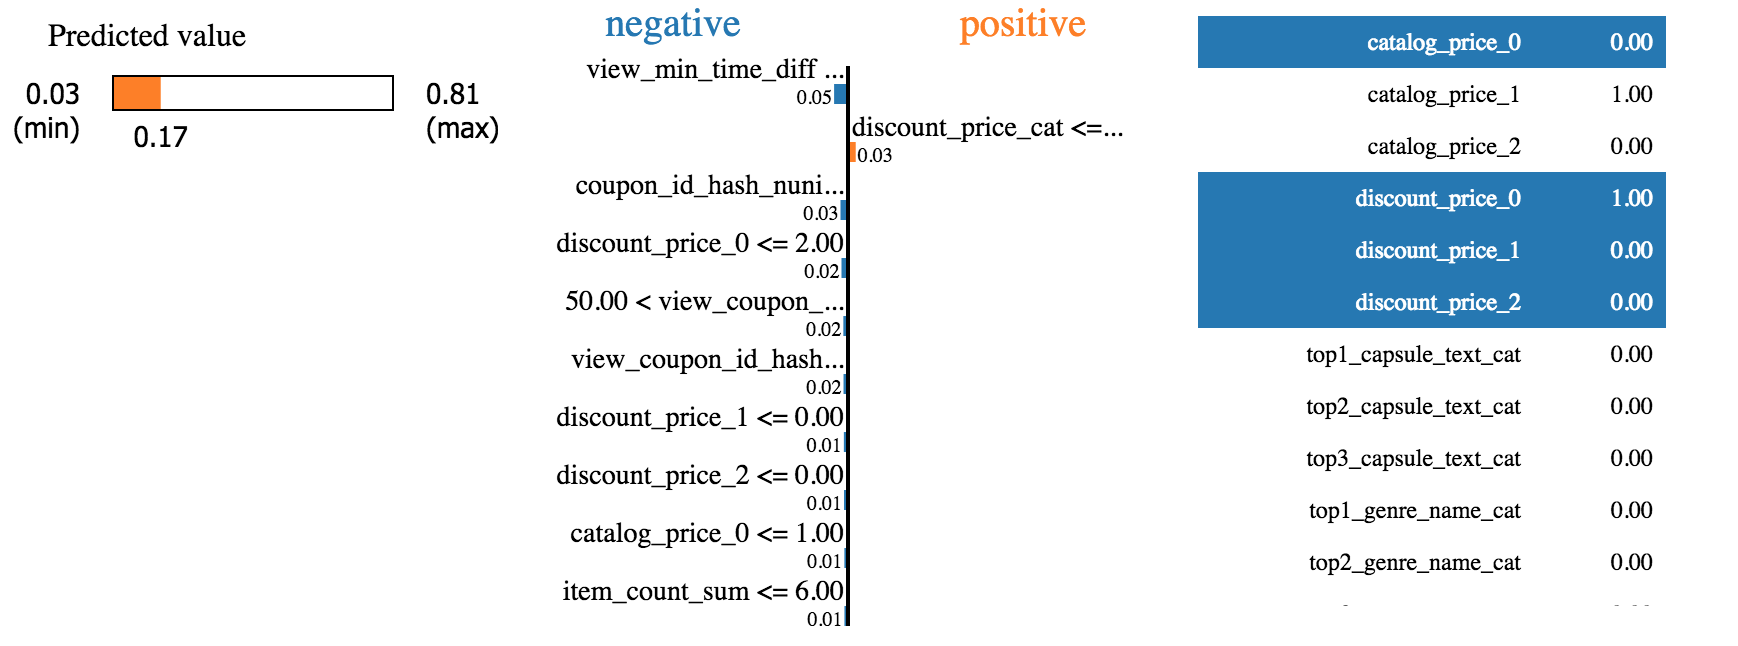

In [58]:
from IPython.display import Image
PATH = "/home/ubuntu/projects/RecoTour/datasets/Ponpare/data_processed/lime_result.png"
Image(filename = PATH, width=800, height=80)

If you run the code and obtain the real plot, you can scroll through the table in the right side of the figure.

The way this should be read is: if the `discount_price_cat` was greater than 0 (everything else held equal), the predicted value would be: `0.17 - 0.03 = 0.14`. 

Let's visualize the results using shap. When using shap, if I use the whole validation dataset, this takes "forever". Therefore, I will use here a subsample of 100000 observations.

In [60]:
start = time()
# shap.initjs()
shap_explainer = shap.TreeExplainer(model)
X_valid_rn = X_valid[random.sample(range(X_valid.shape[0]),100000)]
valid_shap_vals = shap_explainer.shap_values(X_valid_rn)
end = time() - start
print("{} min".format(round(end/60., 3)))

7.114 min


100000 observations took over 7min...

In [61]:
shap.force_plot(shap_explainer.expected_value, valid_shap_vals[0, :], feature_names=all_cols)

Javascript libraries are blocked in github, so you will have to run the code to see the original plot. Below is a screen capture 

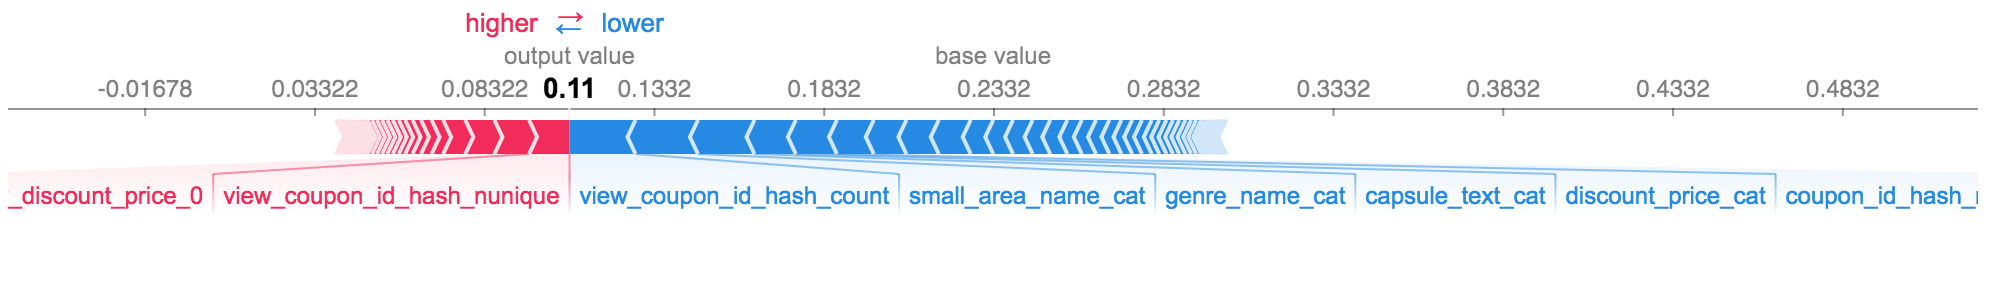

In [63]:
PATH = "/home/ubuntu/projects/RecoTour/datasets/Ponpare/data_processed/shap_result.png"
Image(filename = PATH, width=1000, height=80)

Blue features pushed this particular observation (user+item features) to lower values of interest while red ones push the prediction higher relative to a base value (i.e. a bias) 0.2332. If you look closer, the results are interesting.

We can do a few more plots with shap. Such as this good looking one, where we can examine the impact of each feature in the output of the model:

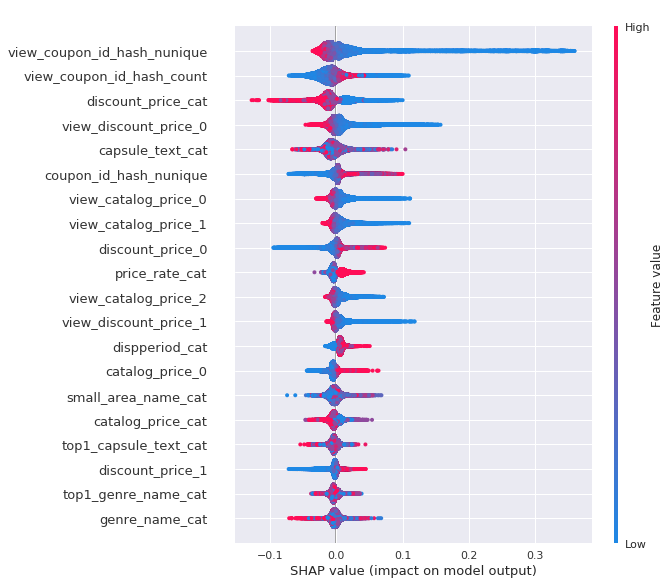

In [64]:
shap.summary_plot(valid_shap_vals, X_valid_rn, feature_names=all_cols)

Let's comment on a couple of features. As expected, low discount-price lead to a higher interest (everyone likes a good offer!). However, and interestingly, the higher is the number of unique coupons viewed (but not bought) the lower is the predicted interest. Given that our meassure of interest is "biased" towards purchases, this possibly reflects the fact that a lot of customers will just navigate through the site but will not buy anything. To me, this means that there is room to improvement in terms of how our meassure of interest is defined. Finding a way of representing negative feedback will almost certainly help improving our MAP. 

Let's have a look to the dependency plot for `view_coupon_id_hash_nunique` (feature 44). The plot below represents the change in SHAP values as `view_coupon_id_hash_nunique` changes, color encoded based on the number of coupons viewd (not unique, but total).We can see that SHAP values sharply decrease as `view_coupon_id_hash_nunique` increases. At the moment of writing, I'd say `view_coupon_id_hash_nunique` gives a sense of "user efficiency", interpreted as how many coupons ones visits (but not buys) relative to the amount of coupons that one buys.  Noneteless, I am convinced a better interest metric is possible. I will leave to you to think of a better way of defining interest so that there is some representation of negative feedback.

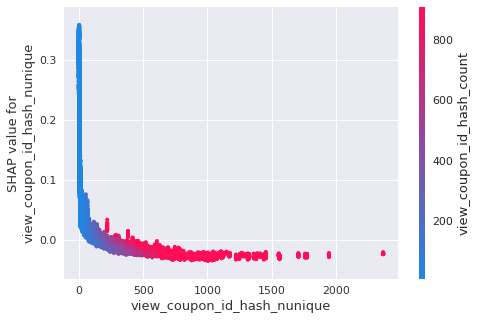

In [65]:
shap.dependence_plot(44, valid_shap_vals, X_valid_rn, feature_names=all_cols)

With this we finih with the GBM approach. In the `py_scripts` directory there is a python scripts similar to the one here but using the `lambdarank` method with `lightGBM`. I will not describe the approach in detail because: 1) it is very similar to the one here, 2) I did not manage to obtain any decent metric and 3) I believe our metric of insterest is not suited for that method. 

Nonetheless, the script is there in case you are curious. Now, onto Factorization Machines.